In [1]:
# Import Statements

# The Columbia Gastric Primary CISNET project
# Author: Matthew Prest, mp4090@cumc.columbia.edu
# Author: Stephanie Shue, sys2131@cumc.columbia.edu
# Single Race/Ethnicity

# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps


# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



# Model Setup, Inputs, Targets

In [2]:
# Loading inputs and setting global parameters
# Global Parameters
starting_age = 18
max_age = 84
N = 100000  # Size of sample populations

# State Structure
health_states = {'Healthy':0,'H. Pylori':1,'Atrophic Gastritis':2, 'AG (HP)':3,'Intestinal Metaplasia':4, 'IM (HP)':5, 'Dysplasia':6, 'Dysplasia (HP)':7,
                'Undetected GC I':8, 'Undetected GC II':9, 'Undetected GC III':10, 'Undetected GC IV':11, 
                'Detected GC I':12,'Detected GC II':13,'Detected GC III':14,'Detected GC IV':15, 
                'Cancer Death':16, 'Other Death':17}

# Age Groupings
sexes = ['Female','Male']
races = ['NH Black','NH White']
ages = {"18-29":0, "30-39":1, "40-49":2, "50-54":3, "55-59":4, "60-64":5, "65-69":6, "70-74":7, "75-79":8, "80-84":9}

## Input: Lifetable Generator

In [3]:
# Other Death tprobs
# Loading lifetables from Zach
lt = pd.read_csv("Inputs and Targets//lifetables.csv")
lt = lt.sort_values(by=['Race','Sex','age'])
lt = lt['Rate'].to_numpy().reshape(2,2,101)[:,:,[25,35,45,52,57,62,67,72,77,82]]
lt = 1 - (1-lt)**(1/12)
lt = lt.T  # Shape (10,2,2) age, sex, race

In [4]:

# Adding background mortality
# MODIFIES INPUT!
def all_cause_mort(matrix):
    matrix[0,0,:,17,0] = lt[:,0,0]  # NH Black Female
    matrix[0,1,:,17,0] = lt[:,0,1]  # NH White Female
    matrix[1,0,:,17,0] = lt[:,1,0]  # NH Black Male
    matrix[1,1,:,17,0] = lt[:,1,1]  # NH White Male
    for i in range(1,16):
        matrix[:,:,:,17,i] = matrix[:,:,:,17,0]
    return matrix


## Input: SEER Survival

In [5]:

# Cancer Death tprobs: Loading SEER Survival
seer_surv = pd.read_csv("Inputs and Targets//Survival (Basecase).csv")[['Age','Sex','Race','CD']].dropna()
seer_surv = seer_surv['CD'].to_numpy().reshape(2,2,9)  # sex, race, age
seer_surv = np.concatenate((seer_surv, np.zeros((2,2,1))), axis=2)
seer_surv[:,:,9] = 1.1*seer_surv[:,:,8]


In [6]:

# Adding SEER survival
# MODIFIES INPUT!
def seer(matrix):
    matrix[0,0,:,16,12] = seer_surv[1,1,:]  # NH Black Female
    matrix[0,1,:,16,12] = seer_surv[1,0,:]  # NH White Female
    matrix[1,0,:,16,12] = seer_surv[0,1,:]  # NH Black Male
    matrix[1,1,:,16,12] = seer_surv[0,0,:]  # NH White Male
    for i in range(13,16):
        matrix[:,:,:,16,i] = matrix[:,:,:,16,12]
    return matrix


## Input: [HP Infection Generator](https://jorgeroa.shinyapps.io/Hpgenerator/)

In [7]:
from src.utils import *
# Loading HP (same for female and male within race)
prev_data = pd.read_csv("Inputs and Targets//Prevalences.csv")
hp_18 = 0.01*prev_data[prev_data['State'] == 'HP']['Prevalence'].to_numpy()[[0,1]]
hp_foi = pd.read_csv("Inputs and Targets//HP (Basecase).csv")
starting_pop = np.zeros((len(sexes), len(races), len(health_states), 1))
starting_pop[0,0,0] = N*(1-hp_18[0])
starting_pop[0,0,1] = N*(hp_18[0])
starting_pop[1,0,0] = N*(1-hp_18[0])
starting_pop[1,0,1] = N*(hp_18[0])
starting_pop[0,1,0] = N*(1-hp_18[1])
starting_pop[0,1,1] = N*(hp_18[1])
starting_pop[1,1,0] = N*(1-hp_18[1])
starting_pop[1,1,1] = N*(hp_18[1])
hp_prob = pd.DataFrame(hp_foi)
hp_prob[['NH White', 'NH Black']] = hp_foi[['NH White', 'NH Black']].apply(lambda x: rate_to_prob(x, 1/12))  # Converting from Annual Rate to Monthly Prob


In [9]:

# Adding HP generator values
def hp(matrix):
    # MODIFIES INPUT!
    age_index = [7,17,27,34,39,44,49,54,59,64]
    matrix[0,0,:,1,0] = np.array([hp_prob['NH Black'][age] for age in age_index])
    matrix[1,0,:,1,0] = np.array([hp_prob['NH Black'][age] for age in age_index])
    matrix[0,1,:,1,0] = np.array([hp_prob['NH White'][age] for age in age_index])
    matrix[1,1,:,1,0] = np.array([hp_prob['NH White'][age] for age in age_index])
    matrix[:,:,:,3,2] = matrix[:,:,:,1,0]
    matrix[:,:,:,5,4] = matrix[:,:,:,1,0]
    matrix[:,:,:,7,6] = matrix[:,:,:,1,0]
    return matrix


## Target: SEER Stage-Specific Incidence

In [10]:

# Loading SEER Incidence
incidence = np.load("Inputs and Targets//Incidence.npy")  # Shape (2,2,67,4)  sex, race, age, stage, this is stage distribution fraction
inc_raw = pd.read_csv("Inputs and Targets//Incidence (Basecase).csv").sort_values(by=['Sex','Race','Age'])

bf = inc_raw[(inc_raw['Sex'] == 'Female') & (inc_raw['Race'] == 'NH Black')]
wf = inc_raw[(inc_raw['Sex'] == 'Female') & (inc_raw['Race'] == 'NH White')]
bm = inc_raw[(inc_raw['Sex'] == 'Male') & (inc_raw['Race'] == 'NH Black')]
wm = inc_raw[(inc_raw['Sex'] == 'Male') & (inc_raw['Race'] == 'NH White')]

# Interpolating the new raw data
inc_raw = inc_raw['Rate'].to_numpy().reshape(2,2,9)  # sex, race, age
inc_raw = csaps([37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5], inc_raw, smooth=0.01, axis=2)(np.linspace(18,84,67)).clip(0.0, 100.0)

# Multiply total stage incidence by stage distribution proportions to get incidence by stage
incidence = incidence * inc_raw[..., np.newaxis] # (sex: 2, race: 2, age: 67, stage: 4)


## Target: Precursor Prevalences

In [11]:

# Loading Prevalence Estimates
prev_data = pd.read_csv("Inputs and Targets//Prevalences.csv")

# Dr. Genta Estimates
im_prev = prev_data[prev_data['State'].isin(['IM','IM HP'])]
im_prev = im_prev['Prevalence'].to_numpy().reshape(2,2,11)  # sex, HP status, age
im_prev = 0.01*csaps([30,42,47,52,57,62,67,72,77,82,92], im_prev, smooth=0.01, axis=2)(np.linspace(18,84,67)).clip(0.0, 100.0)
im_or = prev_data[prev_data['State'] == 'IM OR']['Prevalence']  # AGA paper

# Duco&Anne prevalence meta-analysis
dysplasia_target = 0.01*prev_data[prev_data['State'] == 'Dys']['Prevalence']  # Overall Dys lifetime prevalence
ag_target = 0.01*prev_data[prev_data['State'] == 'AG' ]['Prevalence'].to_numpy() # Overall AG lifetime prevalence
dysplasia_target
# no_hp_ag_target = 0.01*prev_data[prev_data['State'] == 'No HP AG' ]['Prevalence'].to_numpy() # percent of HP negative with AG
# hp_ag_target = 0.01*prev_data[prev_data['State'] == 'HP AG' ]['Prevalence'].to_numpy() # percent of HP positive with AG


8    0.01
Name: Prevalence, dtype: float64

# Transition Matrix
- Shape: (sexes: (0 - F, 1 - M), races: (0 - B, 1 - W), ages: 10, health_states: 18, health_states: 18)

Transition Matrix Helper Functions. <strong>THESE MODIFY THE MATRIX IN PLACE!!<strong>

In [58]:
# Defining Functions

# Adding Relational Constraints
def constrain(matrix):
    # Race/Ethnicity, non-HP transistions not different across race/ethnicity
    matrix[:,1,:,2,0] = matrix[:,0,:,2,0]
    matrix[:,1,:,4,2] = matrix[:,0,:,4,2]
    matrix[:,1,:,6,4] = matrix[:,0,:,6,4]
    matrix[:,1,:,8,6] = matrix[:,0,:,8,6]

    # Sex transitions of precursors
    matrix[1,:,:,2,0] = np.maximum(matrix[1,:,:,2,0], matrix[0,:,:,2,0])
    matrix[1,:,:,4,2] = np.maximum(matrix[1,:,:,4,2], matrix[0,:,:,4,2])
    matrix[1,:,:,6,4] = np.maximum(matrix[1,:,:,6,4], matrix[0,:,:,6,4])
    matrix[1,:,:,8,6] = np.maximum(matrix[1,:,:,8,6], matrix[0,:,:,8,6])
    matrix[1,:,:,9,8] = np.maximum(matrix[1,:,:,9,8], matrix[0,:,:,9,8])
    matrix[1,:,:,10,9] = np.maximum(matrix[1,:,:,10,9], matrix[0,:,:,10,9])
    matrix[1,:,:,11,10] = np.maximum(matrix[1,:,:,11,10], matrix[0,:,:,11,10])
    
    # Cascade Effect
    matrix[:,:,:,4,2] = np.maximum(matrix[:,:,:,2,0], matrix[:,:,:,4,2]) # AG -> IM greater than H -> AG
    matrix[:,:,:,6,4] = np.maximum(matrix[:,:,:,6,4],
                                   matrix[:,:,:,2,0],
                                   )
    matrix[:,:,:,8,6] = np.maximum.reduce([matrix[:,:,:,4,2],
                                           matrix[:,:,:,6,4],
                                           matrix[:,:,:,8,6]]) # DYS -> UGC1 greater than AG -> IM and IM -> DYS

    # # Age trend of precursors (flat or increasing)
    matrix[:,:,:-2,[2, 4, 6, 8], [0, 2, 4, 6]] = np.maximum.accumulate(matrix[:,:,:-2,[2, 4, 6, 8], [0, 2, 4, 6]], axis=2)

    # This is to limit the exponetial increase when we move to run the microsim to age 100
    matrix[:,:,8,:,:] = np.minimum(matrix[:,:,8,:,:],matrix[:,:,7,:,:])
    matrix[:,:,9,:,:] = np.minimum(matrix[:,:,9,:,:],matrix[:,:,8,:,:])

    # HP Effect
    matrix[:,:,:,3,1] = np.maximum(2*matrix[:,:,:,2,0], matrix[:,:,:,3,1])
    matrix[:,:,:,5,3] = np.maximum(2*matrix[:,:,:,4,2], matrix[:,:,:,5,3])
    matrix[:,:,:,7,5] = np.maximum(2*matrix[:,:,:,6,4], matrix[:,:,:,7,5])
    matrix[:,:,:,8,7] = np.maximum(2*matrix[:,:,:,8,6], matrix[:,:,:,8,7])

    # Regression from AG
    matrix[:,:,:,0,2] = np.minimum(matrix[:,:,:,2,0], matrix[:,:,:,0,2]) # AG -> H less than H -> AG
    matrix[:,:,:,1,3] = np.minimum(matrix[:,:,:,3,1], matrix[:,:,:,1,3]) # AG -> H less than HP -> AG (HP)
    matrix[:,:,:,0,2] = np.minimum(0.003831216, matrix[:,:,:,0,2]) # AG -> H less than rate after HP eradication from literature
    matrix[:,:,:,1,3] = np.minimum(0.003831216, matrix[:,:,:,1,3]) # AG (HP) -> HP less than rate after HP eradication from literature
    
    # Diffuse
    matrix[:,:,:,8,1] = matrix[:,:,:,8,0]
    matrix[:,:,:,8,2] = matrix[:,:,:,8,0]
    matrix[:,:,:,8,4] = matrix[:,:,:,8,0]
    matrix[:,:,:,8,3] = matrix[:,:,:,8,0]
    matrix[:,:,:,8,5] = matrix[:,:,:,8,0]

    # Progression Block
    # Sojourn Times from literature
    matrix[:,:,:,9,8] = np.maximum(0.008251752, matrix[:,:,:,9,8])
    matrix[:,:,:,10,9] = np.maximum(0.011552453, matrix[:,:,:,10,9])
    matrix[:,:,:,11,10] = np.maximum(0.014440566, matrix[:,:,:,11,10])

    matrix[:,:,:,10,9] = np.maximum(matrix[:,:,:,9,8], matrix[:,:,:,10,9])
    matrix[:,:,:,11,10] = np.maximum(matrix[:,:,:,10,9], matrix[:,:,:,11,10])

    matrix[:,:,:,9,8] = np.minimum(0.077016353, matrix[:,:,:,9,8])
    matrix[:,:,:,10,9] = np.minimum(0.11552453, matrix[:,:,:,10,9])
    matrix[:,:,:,11,10] = np.minimum(0.23104906, matrix[:,:,:,11,10])
    
    # Detection Block
    matrix[:,:,:,13,9] = np.maximum(matrix[:,:,:,12,8], matrix[:,:,:,13,9])
    matrix[:,:,:,14,10] = np.maximum(matrix[:,:,:,13,9], matrix[:,:,:,14,10])
    matrix[:,:,:,15,11] = np.maximum(matrix[:,:,:,14,10], matrix[:,:,:,15,11])
    
    return matrix

# Normalizing Columns
def col_normalize(matrix):
    matrix = np.clip(matrix, 0.0, 0.6)
    # Iterate over the first three dimensions to access each 18x18 matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for k in range(matrix.shape[2]):
                layer = matrix[i, j, k]
                # Calculate the sum of non-diagonal elements for each column
                sum_of_columns = np.sum(layer, axis=0) - np.diag(layer)
                # Set the diagonal elements
                np.fill_diagonal(layer, 1 - sum_of_columns)
    return matrix

Create Transition Matrix with starting values (arbitrary values that give a good starting fit)

In [59]:
# Creating Transition Matrix
def create(ages=ages, health_states=health_states):
    matrix = np.zeros((len(sexes), len(races), len(ages), len(health_states), len(health_states)))  # Shape (2,2,10,18,18)
    # For starting values, trial and error to find constant values that give a decent starting fit
    # Creating Base layer
    # matrix[:,:,1:,2,0] = 0.0001  # healthy -> AG
    # matrix[:,:,8:,2,0] = 0.0 # healthy -> AG
    # matrix[:,:,1:,4,2] = 0.0008  # AG -> IM
    # matrix[:,:,9:,4,2] = 0.0 # AG -> IM
    # matrix[1,:,1:,4,2] = 0.0011  # AG -> IM, Male
    # matrix[:,:,1:,6,4] = 0.000009  # IM -> DYS
    # matrix[1,:,1:,6,4] = 0.000012  # IM -> DYS, Male
    # matrix[:,:,1:,8,6] = 0.003  # DYS -> U GC 1
    # matrix[1,:,1:,8,6] = 0.005  # DYS -> U GC 1, Male
    # # Progression
    # matrix[:,:,1:,9,8] = 0.019254088  # median sojourn time estiamtes
    # matrix[:,:,1:,10,9] = 0.028881133
    # matrix[:,:,1:,11,10] = 0.077016353
    # # Detection
    # matrix[:,:,1:,12,8] = 0.006
    # matrix[:,:,1:,13,9] = 0.008
    # matrix[:,:,1:,14,10] = 0.03
    # matrix[:,:,1:,15,11] = 0.18

    # # Diffuse
    # matrix[0,0,3:,8,0] = 0.0000010  # Diffuse, BF
    # matrix[0,0,4:,8,0] = 0.0000015  # Diffuse, BF
    # matrix[0,0,5:,8,0] = 0.0000020  # Diffuse, BF
    # matrix[0,0,6:,8,0] = 0.0000015  # Diffuse, BF

    # matrix[0,1,3:,8,0] = 0.0000003  # Diffuse, WF
    # matrix[0,1,4:,8,0] = 0.0000006  # Diffuse, WF
    # matrix[0,1,5:,8,0] = 0.0000009  # Diffuse, WF
    # matrix[0,1,6:,8,0] = 0.0000012  # Diffuse, WF

    # matrix[1,0,3:,8,0] = 0.0000016  # Diffuse, BM
    # matrix[1,0,4:,8,0] = 0.0000024  # Diffuse, BM
    # matrix[1,0,5:,8,0] = 0.0000032  # Diffuse, BM
    # matrix[1,0,6:,8,0] = 0.0000040  # Diffuse, BM

    # matrix[1,1,3:,8,0] = 0.0000003  # Diffuse, WM
    # matrix[1,1,4:,8,0] = 0.0000006  # Diffuse, WM
    # matrix[1,1,5:,8,0] = 0.0000009  # Diffuse, WM
    # matrix[1,1,6:,8,0] = 0.0000012  # Diffuse, WM

    # matrix[:,:,9:,8,0] = 0.0  # Diffuse

    # Progression to AG
    # matrix[:,:,1:,2,0] = 0.0001  # healthy -> AG
    # matrix[1:,:,1:,2,0] = 0.0002  # healthy -> AG, Male
    matrix[:,:,1:,2,0] = 0.0002  # healthy -> AG
    matrix[1:,:,1:,2,0] = 0.0003  # healthy -> AG, Male
    matrix[:,:,9:,2,0] = 0.0 # healthy -> AG, 80+

    # Regression from AG (from literature)
    matrix[:,:,1:,0,2] = 0.000144873 # AG -> healthy
    matrix[:,:,9:,0,2] = 0.0 # AG -> healthy, 80+
    matrix[:,:,1:,1,3] = 0.001299308 # AG (HP) -> HP
    matrix[:,:,9:,1,3] = 0.0 # AG (HP) -> HP, 80+

    # Progression to IM
    matrix[:,:,1:,4,2] = 0.001  # AG -> IM
    matrix[1,:,1:,4,2] = 0.001  # AG -> IM, Male
    matrix[:,:,8:,4,2] = 0.0001 # AG -> IM, 75+
    matrix[:,:,9:,4,2] = 0.0 # AG -> IM, 80+
    
    # Progression to Dysplasia
    matrix[:,:,1:,6,4] = 0.0005  # IM -> DYS
    matrix[1,:,1:,6,4] = 0.0005  # IM -> DYS, Male
    matrix[:,:,8:,6,4] = 0.0002 # IM -> DYS, 75+
    # matrix[1:,:,8:,6,4] = 0.000012 # IM -> DYS, 75+, Male
    # matrix[:,:,9:,6,4] = 0.0000005 # IM -> DYS, 80+
    # matrix[1:,:,9:,6,4] = 0.000001 # IM -> DYS, 80+, Male
    matrix[:,:,9:,6,4] = 0.0001 # IM -> DYS, 80+
    # matrix[1:,:,9:,6,4] = 0.000012 # IM -> DYS, 80+, Male

    # Progression to UGC1
    matrix[:,:,1:,8,6] = 0.002  # DYS -> U GC 1
    # matrix[1,:,1:,8,6] = 0.003  # DYS -> U GC 1, Male
    matrix[1,:,8:,8,6] = 0.001 # DYS -> U GC 1, 75+, Male
    # matrix[1,:,9:,8,6] = 0.0001 # DYS -> U GC 1, 80+, Male
    
    # Progression (UGC)
    matrix[:,:,1:,9,8] = 0.019254088  # median sojourn time estimates
    matrix[:,:,1:,10,9] = 0.028881133
    matrix[:,:,1:,11,10] = 0.077016353

    # Detection (DGC)
    matrix[:,:,1:,12,8] = 0.006
    matrix[:,:,1:,13,9] = 0.008
    matrix[:,:,1:,14,10] = 0.03
    matrix[:,:,1:,15,11] = 0.18

    # Diffuse
    matrix[0,0,3:,8,0] = 0.0000006  # Diffuse, BF
    # matrix[0,0,4:,8,0] = 0.0000010  # Diffuse, BF
    # matrix[0,0,5:,8,0] = 0.0000015  # Diffuse, BF
    # matrix[0,0,6:,8,0] = 0.0000020  # Diffuse, BF

    matrix[0,1,3:,8,0] = 0.0000002  # Diffuse, WF
    # matrix[0,1,4:,8,0] = 0.0000001  # Diffuse, WF
    # matrix[0,1,5:,8,0] = 0.0000004  # Diffuse, WF
    # matrix[0,1,6:,8,0] = 0.0000007  # Diffuse, WF

    matrix[1,0,3:,8,0] = 0.0000011  # Diffuse, BM
    # matrix[1,0,4:,8,0] = 0.0000019  # Diffuse, BM
    # matrix[1,0,5:,8,0] = 0.0000027  # Diffuse, BM
    # matrix[1,0,6:,8,0] = 0.0000035  # Diffuse, BM

    matrix[1,1,3:,8,0] = 0.0000002  # Diffuse, WM
    # matrix[1,1,4:,8,0] = 0.0000001  # Diffuse, WM
    # matrix[1,1,5:,8,0] = 0.0000004  # Diffuse, WM
    # matrix[1,1,6:,8,0] = 0.0000007  # Diffuse, WM

    matrix[:,:,8:,8,0] = 0.00000005  # Diffuse, 75+
    matrix[:,:,9:,8,0] = 0.0  # Diffuse, 80+

    matrix = constrain(matrix)
    matrix = all_cause_mort(matrix)
    matrix = seer(matrix)
    matrix = hp(matrix)
    matrix = col_normalize(matrix)
    return matrix


# Run Markov

In [14]:
# Running Markov Model
def run(matrix, max_age=84):
    current_age = starting_age
    i = 1
    pop, pop_log = starting_pop, starting_pop  # Shape (2,2,18,1)
    inflow_matrix = np.tril(matrix, k=-1)
    incidence = np.zeros((2,2, len(health_states), 1)) # To keep track of how many enter a state
    age_layer = 0
    while current_age <= max_age:
        month_inc = np.matmul(inflow_matrix[:,:,age_layer,:,:], pop)
        pop = np.matmul(matrix[:,:,age_layer,:,:], pop)
        incidence = np.concatenate((incidence, month_inc), axis=3)
        pop_log = np.concatenate((pop_log, pop), axis=3)
        i += 1
        if i % 12 == 0:
            current_age += 1
            if current_age in [30,40,50,55,60,65,70,75,80]:
                age_layer += 1

    dead_factor = np.divide(N, N-pop_log[:,:,16:,:].sum(axis=2))  # Incidence and prevalence denom should be living only
    prevalence = np.zeros(pop_log.shape)
    for state in range(18):
        incidence[:,:,state,:] = np.multiply(incidence[:,:,state,:], dead_factor)  # Applying correction
        prevalence[:,:,state,:] = np.multiply(pop_log[:,:,state,:], dead_factor)  # Applying correction

    incidence = incidence.reshape(2,2,len(health_states),67,12).sum(axis=4)  # Annualizing
    prevalence = prevalence.reshape(2,2,len(health_states),67,12).mean(axis=4)  # Getting mean annual prevalence

    return incidence, prevalence

# Calibration

In [28]:
# Adjust transition matrix (8,0)
calibrated_trans = [
                    (2,0,'Healthy -> AG'),
                    (0,2,'AG -> Healthy'),
                    (3,1,'HP -> AG (HP)'),
                    (1,3,'AG (HP) -> HP'),
                    (4,2,'AG -> IM'),
                    (5,3,'AG (HP) -> IM (HP)'),
                    (6,4,'IM -> DYS'),
                    (7,5,'IM (HP) -> DYS (HP)'),
                    (8,6,'DYS -> U GC 1'),
                    (8,7,'DYS (HP) -> U GC 1'),
                    (8,0,'Healthy -> U GC 1'),
                    (9,8,'U GC 1 -> U GC 2'),
                    (10,9,'U GC 2 -> U GC 3'),
                    (11,10,'U GC 3 -> U GC 4'),
                    (12,8,'U GC 1 -> D GC 1'),
                    (13,9,'U GC 2 -> D GC 2'),
                    (14,10,'U GC 3 -> D GC 3'),
                    (15,11,'U GC 4 -> D GC 4'),
                    ]
def step(matrix, step_size, num_adj=10, smooth=0.01): # max num adj
    num_adj=min(num_adj, 10*2*2*len(calibrated_trans))
    layers, cells = np.random.randint(10, size=num_adj), np.where(np.random.multinomial(1, [1/len(calibrated_trans)]*len(calibrated_trans), size=num_adj) == 1)[1]
    r_e = np.random.randint(0,2,num_adj)
    for i in range(num_adj):
        matrix[r_e[i], r_e[num_adj-i-1], layers[i], calibrated_trans[cells[i]][0], calibrated_trans[cells[i]][1]] += np.random.uniform(low=-step_size, high=step_size)

    matrix = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], matrix, smooth=smooth, axis=2)([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5]).clip(0.0, 1.0)
    matrix = constrain(matrix)
    matrix = all_cause_mort(matrix)
    matrix = seer(matrix)
    matrix = hp(matrix)
    matrix = col_normalize(matrix)
    return matrix

WEIGHTS = {
        "raw": { # proportional weighting by raw sample size
            "Inc": 1,
            "IM Prev W": 0.0272,
            "IM Prev B": 4.275e5,
            "AG Prev": 0.0132,
            "Dys Prev": 0.0175,
        },
        "sqrt": { # proportional weighting by square root of sample size
            "Inc": 1,
            "IM Prev W": 0.1649,
            "IM Prev B": 0.0065,
            "AG Prev": 0.1147,
            "Dys Prev": 0.1321,
        }
    }

# Calculate Objective
def objective(log, weight_type="sqrt"):
    """Multi-objective optimization via weighted sum-squared error method. Weights are assigned by sample size of target data.

    Args:
        log (tuple): tuple of incidence and prevalence arrays (sex: 2, race: 2, state: 18, age: 67)
        weight_type (str, optional): Whether to use weights dependent on raw or sqrt of sample size. Defaults to "sqrt".

    Returns:
        score: total error
        weighted_error: dictionary of each error component (weighted)
    """
    # inc (sex: 2, race: 2, state: 18, age: 67)
    # prev (sex: 2, race: 2, state: 18, age: 67)
    inc, prev = log[0], log[1]

    weights = WEIGHTS[weight_type]
    
    err = {
        "Inc": 0,
        "IM Prev W": 0,
        "IM Prev B": 0,
        "AG Prev": 0,
        "Dys Prev": 0,
    }

    # Each error is on the scale of # per 100k. Targets that are more stratified (race, sex, age) contribute more to the score because of the additive nature.
    
    ## STAGE-SPECIFIC INCIDENCE
    err["Inc"] += weights["Inc"]*np.square(inc[:,0,12,:] - incidence[:,0,:,0]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,0,13,:] - incidence[:,0,:,1]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,0,14,:] - incidence[:,0,:,2]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,0,15,:] - incidence[:,0,:,3]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,1,12,:] - incidence[:,1,:,0]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,1,13,:] - incidence[:,1,:,1]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,1,14,:] - incidence[:,1,:,2]).sum()
    err["Inc"] += weights["Inc"]*np.square(inc[:,1,15,:] - incidence[:,1,:,3]).sum()
    # print("model Inc", inc[:,0,12,:], "target", incidence[:,0,:,0])
    # print("diff", inc[:,0,12,:] - incidence[:,0,:,0])
    # print("square sum", weights["Inc"]*np.square(inc[:,0,12,:] - incidence[:,0,:,0]).sum())

    ## PRECURSOR PREVALENCE
    # NH White IM prevalence by age
    err["IM Prev W"] += weights["IM Prev W"]*np.square(prev[:,1,4,:] - N*im_prev[:,0,:]).sum()/N  # NH White, IM no HP
    err["IM Prev W"] += weights["IM Prev W"]*np.square(prev[:,1,5,:] - N*im_prev[:,1,:]).sum()/N  # NH White, IM with HP
    # print("model IM Prev W, no HP", prev[:,1,4,:], "target", N*im_prev[:,0,:])
    # print("diff", prev[:,1,4,:] - N*im_prev[:,0,:])
    # print("square sum", weights["IM Prev W"]*np.square(prev[:,1,4,:] - N*im_prev[:,0,:]).sum())

    # Estimated NH Black IM prevalence by age (multiply NH white prevalence by Black/White odds ratio)
    # err["IM Prev B"] += weights["IM Prev B"]*np.square(prev[:,0,4,:] + prev[:,0,5,:] - im_or[0]*N*(im_prev[:,0,:] + im_prev[:,1,:])).sum()  # NH Black, IM total
    
    # Overall Lifetime AG prevalence
    err["AG Prev"] += weights["AG Prev"]*np.square((prev[:,:,2,:] + prev[:,:,3,:]).mean(axis=(0,1,2)) - N*ag_target).sum()/N  # AG
    # score += weights[2]*np.square(prev[:,:,2,:].mean(axis=2) - N*ag_target[0]).sum()/N  # AG no HP
    # score += weights[2]*np.square(prev[:,:,3,:].mean(axis=2) - N*ag_target[1]).sum()/N  # AG with HP
    # print("model AG Prev", (prev[:,:,2,:] + prev[:,:,3,:]).mean(axis=(0,1,2)), "target", N*ag_target)
    # print("diff", (prev[:,:,2,:] + prev[:,:,3,:]).mean(axis=(0,1,2)) - N*ag_target)
    # print("square sum", weights["AG Prev"]*np.square((prev[:,:,2,:] + prev[:,:,3,:]).mean(axis=(0,1,2)) - N*ag_target).sum())

    # Overall Lifetime Dys prevalence
    err["Dys Prev"] += weights["Dys Prev"]*np.square((prev[:,:,6,:] + prev[:,:,7,:]).mean(axis=(0,1,2)) - N*dysplasia_target).sum()/N  # Dys
    # print("model Dys Prev", (prev[:,:,6,:] + prev[:,:,7,:]).mean(axis=(0,1,2)), "target", N*dysplasia_target)
    # print("diff", (prev[:,:,6,:] + prev[:,:,7,:]).mean(axis=(0,1,2)) - N*dysplasia_target)
    # print("square sum", weights["Dys Prev"]*np.square((prev[:,:,6,:] + prev[:,:,7,:]).mean(axis=(0,1,2)) - N*dysplasia_target).sum())
    
    weighted_err = {key: weights[key]*err[key] for key in err.keys()}
    score = sum(weighted_err.values())

    return score, weighted_err

# Iterate
def simulated_annealing(n_iterations, step_size, num_adj = 10, smooth=0.01, starting_temp = 1, starting_mat=None, verbose=False):
    if starting_mat is None:
        best = create()
    else:
        best = np.copy(starting_mat)
    best_eval = objective(run(best))[0]  # evaluate the initial point
    curr, curr_eval = best, best_eval  # current working solution
    for i in range(n_iterations):  # Running algorithm
        candidate = np.copy(curr)
        candidate = step(candidate, step_size, num_adj, smooth)
        candidate_eval = objective(run(candidate))[0]  # Evaluate candidate point
        if candidate_eval < best_eval:
            best, best_eval = candidate, candidate_eval 
        # t = 10 / float(i+1)  # calculate temperature for current epoch
        t = starting_temp /(1+np.log(i+1))
        if verbose and i%(10_000)==0:
            print('>%d score = %.5f' % (i, best_eval))  # report progress         
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr, curr_eval = candidate, candidate_eval  # store the new current point
    print(best_eval)
    return best


# Visualize Outputs

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

def plot_im_prev(prev, save=False, folder="", hide_plot=False):
    # prev (sex: 2, race: 2, state: 18, age: 67)

    # Marker and color mapping
    colors = ["blue", "orange"] # hp

    linestyles = ["--", ":"] # sex

    legend_handles = [
        mlines.Line2D([], [], color='black', linestyle='-', label='Model'),                    # Solid black line for Model
        mlines.Line2D([], [], color='black', linestyle='-', alpha=0.5, label='Target'),         # Half-transparent line for Target
        mlines.Line2D([], [], color='black', linestyle=':', label='Male'),                     # Dotted line for Male
        mlines.Line2D([], [], color='black', linestyle='--', label='Female'),                  # Dashed line for Female
        mlines.Line2D([], [], color='blue', linestyle='-', label='non-HP'),                    # Solid blue line for non-HP
        mlines.Line2D([], [], color='orange', linestyle='-', label='HP')                       # Solid orange line for HP
    ]

    # Create figure and axis
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    x = np.linspace(18, 84, 67)

    ## Plot NH White (HP and non-HP)
    for sex in (0, 1):
        for hp in (0, 1):
            # Model
            ax[0].plot(x, prev[sex,1,4 + hp,:]/1000, color=colors[hp], linestyle=linestyles[sex], label=f'Model {"Female" if not sex else "Male"} {"non-" if not hp else ""}HP')
            # Target
            ax[0].plot(x, 100*im_prev[sex,hp,:], color=colors[hp], linestyle=linestyles[sex], alpha=0.5, label=f'Target {"Female" if not sex else "Male"} {"non-" if not hp else ""}HP')
    ax[0].set_title ("NH White")
    ax[0].legend(handles=legend_handles)

    ## Plot NH Black (overall)
    for sex in (0, 1):
        # Model
        ax[1].plot(x, (prev[sex,0,4,:] + prev[sex,0,5,:])/1000, color="black", linestyle=linestyles[sex], label=f'Model {"Female" if not sex else "Male"} All')
        # Target
        ax[1].plot(x, im_or[0]*100*(im_prev[sex,0,:] + im_prev[sex,1,:]), color="black", linestyle=linestyles[sex], alpha=0.5, label=f'Target {"Female" if not sex else "Male"} All')
    ax[1].set_title("NH Black")
    ax[1].legend(handles=legend_handles[:-2])

    # Add labels and title
    fig.supylabel('Prevalence (%)')
    fig.supxlabel('Age')
    fig.suptitle('IM Prevalence')

    # Display the plot
    plt.tight_layout()
    
    if save:
        fig.savefig(f"{folder}/IM_prevalence.png")
    if hide_plot:
        plt.close()



In [17]:
import matplotlib.pyplot as plt
import numpy as np

# def plot_ag_dys_prev(prev, save=False, folder="", hide_plot=False):
#     ## TARGETS: AG (non-HP) - 5%, AG (HP) - 31%, DYS - 1%
#     # prev (sex: 2, race: 2, state: 18, age: 67)

#     AG = prev[:,:,2,:].mean(axis=2)/1000
#     AG_HP = prev[:,:,3,:].mean(axis=2)/1000
#     DYS = (prev[:,:,6,:].mean(axis=(0,1,2)) + prev[:,:,7,:].mean(axis=(0,1,2)))/1000

#     model_ag_data = {
#         'black_female': [prev[0][0] for prev in (AG, AG_HP)], 
#         'white_female': [prev[0][1] for prev in (AG, AG_HP)],
#         'black_male': [prev[1][0] for prev in (AG, AG_HP)],
#         'white_male': [prev[1][1] for prev in (AG, AG_HP)],
#     }

#     # Marker and color mapping
#     colors = {
#         'black': 'blue',
#         'white': 'orange',
#         'all': 'black'     
#     }

#     markers = {
#         'male': 'x',
#         'female': 'o',
#         'all': '*',
#     }

#     # Create figure and axis
#     fig, ax = plt.subplots()
#     x_labels = ["AG (non-HP)", "AG (HP)", "Dys"]
#     x = [0, 1, 2]

    
#     ax.plot([0, 1], model_ag_data['black_female'], marker=markers['female'], color="none", markeredgecolor=colors['black'], linestyle='None', label='Black Female')
#     ax.plot([0, 1], model_ag_data['black_male'], marker=markers['male'], color=colors['black'], linestyle='None', label='Black Male')
#     ax.plot([0, 1], model_ag_data['white_female'], marker=markers['female'], color="none", markeredgecolor=colors['white'], linestyle='None', label='White Female')
#     ax.plot([0, 1], model_ag_data['white_male'], marker=markers['male'], color=colors['white'], linestyle='None', label='White Male')
#     ax.plot(2, [DYS], marker=markers['all'], color='None', markeredgecolor=colors['all'], markersize=10, linestyle='None',label='Model - All')

#     ax.plot(0, [100*ag_target[0]], marker=markers['all'], color=colors['all'], markersize=10, linestyle='None', label='Target - All')
#     ax.plot(1, [100*ag_target[1]], marker=markers['all'], color=colors['all'], markersize=10, linestyle='None')
#     ax.plot(2, [100*dysplasia_target], marker=markers['all'], color=colors['all'], markersize=10, linestyle='None')

#     # Add labels and title
#     ax.set_ylabel('Prevalence (%)')
#     ax.set_title('AG and Dys Prevalence')
#     ax.set_xticks(x)
#     ax.set_xticklabels(x_labels)
#     ax.legend()

#     # Display the plot
#     plt.tight_layout()

#     if save:
#         fig.savefig(f"{folder}/ag_dys_prevalence.png")
#     if hide_plot:
#         plt.close()

#     return {"AG": {"model": AG, "target": 100*ag_target[0]},
#             "IM Black": {"model": AG_HP, "target": 100*ag_target[1]},
#             "DYS": {"model": DYS, "target": 100*dysplasia_target}}

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_precursor_prev(prev, save=False, folder="", hide_plot=False):
    ## TARGETS: AG - 0.217, IM (Black) - 0.159, IM (White) - 0.122, IM (all) - 0.113, DYS - 0.01
    # prev (sex: 2, race: 2, state: 18, age: 67)

    AG_prev = ((prev[:,:,2,:] + prev[:,:,3,:]).mean(axis=2))/100000
    IM_prev = ((prev[:,:,4,:] + prev[:,:,5,:]).mean(axis=2))/100000
    DYS_prev = ((prev[:,:,6,:] + prev[:,:,7,:]).mean(axis=2))/100000

    model_prevalence_data = {
        'black_female': [prev[0][0] for prev in (AG_prev, IM_prev, DYS_prev)], 
        'white_female': [prev[0][1] for prev in (AG_prev, IM_prev, DYS_prev)],
        'black_male': [prev[1][0] for prev in (AG_prev, IM_prev, DYS_prev)],
        'white_male': [prev[1][1] for prev in (AG_prev, IM_prev, DYS_prev)],
    }

    target_prevalence_data = {
        'black_all': [0.159], # IM
        'white_all': [0.122], # IM
        'all': [0.217, 0.113, 0.01] # AG, IM, DYS
    }

    # Marker and color mapping
    colors = {
        'black': 'blue',
        'white': 'orange',
        'all': 'black'     
    }

    markers = {
        'male': 'x',
        'female': 'o',
        'all': '*',
    }

    # Create figure and axis
    fig, ax = plt.subplots()
    x_labels = ["AG", "IM", "Dys"]
    x = [0, 1, 2]

    
    ax.plot(x, model_prevalence_data['black_female'], marker=markers['female'], color="none", markeredgecolor=colors['black'], linestyle='None', label='Black Female')
    ax.plot(x, model_prevalence_data['black_male'], marker=markers['male'], color=colors['black'], linestyle='None', label='Black Male')
    ax.plot(x, model_prevalence_data['white_female'], marker=markers['female'], color="none", markeredgecolor=colors['white'], linestyle='None', label='White Female')
    ax.plot(x, model_prevalence_data['white_male'], marker=markers['male'], color=colors['white'], linestyle='None', label='White Male')

    ax.plot(1, target_prevalence_data['black_all'], marker=markers['all'], color=colors['black'], markersize=10, linestyle='None', label='Target - Black')
    ax.plot(1, target_prevalence_data['white_all'], marker=markers['all'], color=colors['white'], markersize=10, linestyle='None', label='Target - White')
    ax.plot(x, target_prevalence_data['all'], marker=markers['all'], color=colors['all'], markersize=10, linestyle='None', label='Target - All')

    # Add labels and title
    ax.set_ylabel('Prevalence (%)')
    ax.set_title('Precursor Prevalence')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

    # Display the plot
    plt.tight_layout()

    if save:
        fig.savefig(f"{folder}/precursor_prevalence.png")
    if hide_plot:
        plt.close()

    return {"AG": {"model": AG_prev, "target": 0.08},
            "IM Black": {"model": IM_prev[:,0], "target": 0.159},
            "IM White": {"model": IM_prev[:,1], "target": 0.122},
            "DYS": {"model": DYS_prev, "target": 0.01}}



In [19]:
import matplotlib.pyplot as plt

def plot_incidence_by_stage(inc_results, save=False, folder="", hide_plot=False): # (2, 2, 18, 67)
    model_inc = np.concatenate((np.zeros((2,2,4,18)), inc_results[:,:,12:16,:]), axis=3)
    seer_inc = np.concatenate((np.zeros((2,2,18,4)), incidence), axis=2)

    indices = [(0, 0, "NH Black Female"), (0, 1, "NH White Female"), (1, 0, "NH Black Male"), (1, 1, "NH White Male")]

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Gastric Cancer Stage-Specific Incidence by Age")

    for i, j, title in indices:
        # Plot model data
        axs[i, j].plot(model_inc[i, j, 0, :], label='I', color='r')
        axs[i, j].plot(model_inc[i, j, 1, :], label='II', color='g')
        axs[i, j].plot(model_inc[i, j, 2, :], label='III', color='b')
        axs[i, j].plot(model_inc[i, j, 3, :], label='IV', color='y')
        
        # Plot SEER data
        axs[i, j].plot(seer_inc[i, j, :, 0], alpha=0.5, ls="--", color='r')
        axs[i, j].plot(seer_inc[i, j, :, 1], alpha=0.5, ls="--", color='g')
        axs[i, j].plot(seer_inc[i, j, :, 2], alpha=0.5, ls="--", color='b')
        axs[i, j].plot(seer_inc[i, j, :, 3], alpha=0.5, ls="--", color='y')
        
        axs[i, j].set_title(title)
        axs[i, j].legend()

    plt.tight_layout()

    if save:
        fig.savefig(f"{folder}/incidence_by_stage.png")
    if hide_plot:
        plt.close()


In [20]:
def plot_incidence(inc_results, save=False, folder="", hide_plot=False):
    model_inc_tot = np.concatenate((np.zeros((2,2,4,18)), inc_results[:,:,12:16,:]), axis=3).sum(axis=2)

    indices = [(0, 0, "NH Black Female", bf), (0, 1, "NH White Female", wf), (1, 0, "NH Black Male", bm), (1, 1, "NH White Male", wm)]

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Gastric Cancer Incidence by Age")

    for i, j, title, target in indices:
        axs[i, j].plot(model_inc_tot[i,j,:], label='Model')
        axs[i, j].errorbar(x=target['Age'], y=target['Rate'], yerr=[target['Rate']-target['Lower'], target['Upper']-target['Rate']], label='Basecase', fmt='o')
        
        axs[i, j].set_title(title)
        axs[i, j].legend()

    plt.tight_layout()

    if save:
        fig.savefig(f"{folder}/incidence.png")
    if hide_plot:
        plt.close()


In [13]:
# # Getting Diffuse Prev estimates
# print(f"BF Diffuse Fraction: {model_inc[0,0,:,:].sum(axis=(0,1))/seer_inc[0,0,:,:].sum(axis=(0,1))}, target: 0.23")
# print(f"WF Diffuse Fraction: {model_inc[0,1,:,:].sum(axis=(0,1))/seer_inc[0,1,:,:].sum(axis=(0,1))}, target: 0.26")
# print(f"BM Diffuse Fraction: {model_inc[1,0,:,:].sum(axis=(0,1))/seer_inc[1,0,:,:].sum(axis=(0,1))}, target: 0.14")
# print(f"WM Diffuse Fraction: {model_inc[1,1,:,:].sum(axis=(0,1))/seer_inc[1,1,:,:].sum(axis=(0,1))}, target: 0.17")

# Run calibration

In [21]:
import os

def run_calibration(num_iters = 10_000, step_size=0.1, num_adj=10, smooth=0.01, starting_temp = 1, starting_tmat=None, starting_tmat_fname=None, start_iter = 0, save=False, hide_plot=False, tmat_name=""):
    folder = f"Transition Matrices/{tmat_name}"

    start_tmat = None
    if starting_tmat is not None:
        start_tmat = starting_tmat
    else:
        start_tmat = create()
    initial_score = objective(run(start_tmat))

    tmat = simulated_annealing(num_iters,
                               step_size,
                               num_adj=num_adj,
                               smooth=smooth,
                               starting_temp=starting_temp,
                               starting_mat=start_tmat,
                               verbose=True) if num_iters > 0 else start_tmat
    inc_results, prev_results = run(tmat)
    final_score = objective((inc_results, prev_results))
    # print("Calibrated tmat check", np.amin(tmat), np.amax(tmat), final_score)

    # Only save if save is True and either running or calibrating and the score has changed
    is_initial = num_iters == 0
    is_diff= final_score != initial_score
    save = save and (is_initial or (not is_initial and is_diff))
    if save:
        print("Saving log...")
        os.makedirs(folder, exist_ok=True)
        # Save tmat
        np.save(f"{folder}/{tmat_name}.npy", tmat)
        # Save log of calibration
        with open(f"{folder}/log.txt", "w") as f:
            # Write text to the file
            if num_iters:
                f.write(f"Start tmat: {starting_tmat_fname if starting_tmat_fname else 'None'}\n")
                f.write(f"Initial score: {initial_score[0]}\n")
                for k, v in initial_score[1].items():
                    f.write(f"\t{k} - {v}\n")
                f.write(f"Starting temp: {starting_temp}\n")
                f.write(f"Starting iter: {start_iter}\n")
                f.write(f"Num iters: {num_iters}\n")
                f.write(f"Step size: {step_size}\n")
                f.write(f"Num adjust: {num_adj}\n")
                f.write(f"Smoothing: {smooth}\n")
                f.write(f"Final score: {final_score[0]}\n")
                for k, v in final_score[1].items():
                    f.write(f"\t{k} - {v}\n")
            else:
                f.write(f"Tmat: {tmat_name}\n")
                f.write(f"Score: {initial_score[0]}\n")
                for k, v in initial_score[1].items():
                    f.write(f"\t{k} - {v}\n")
        print("Done")

    # Plot outputs
    plot_incidence(inc_results, save=save, folder=folder, hide_plot=hide_plot)
    plot_incidence_by_stage(inc_results, save=save, folder=folder, hide_plot=hide_plot)
    plot_im_prev(prev_results, save=save, folder=folder, hide_plot=hide_plot)
    # plot_ag_dys_prev(prev_results, save=save, folder=folder, hide_plot=hide_plot)
    precursor_prevalence = plot_precursor_prev(prev_results, save=save, folder=folder, hide_plot=hide_plot)
    # print("precursor prevalence:", precursor_prevalence)

    return tmat, is_diff

Saving log...
Done


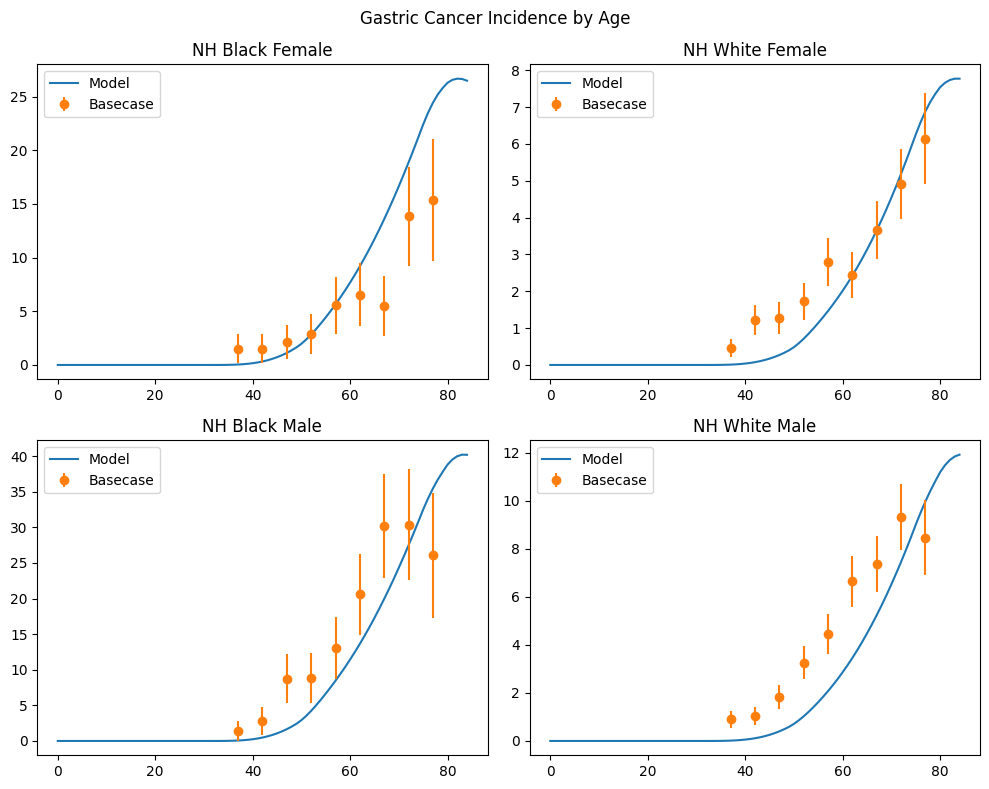

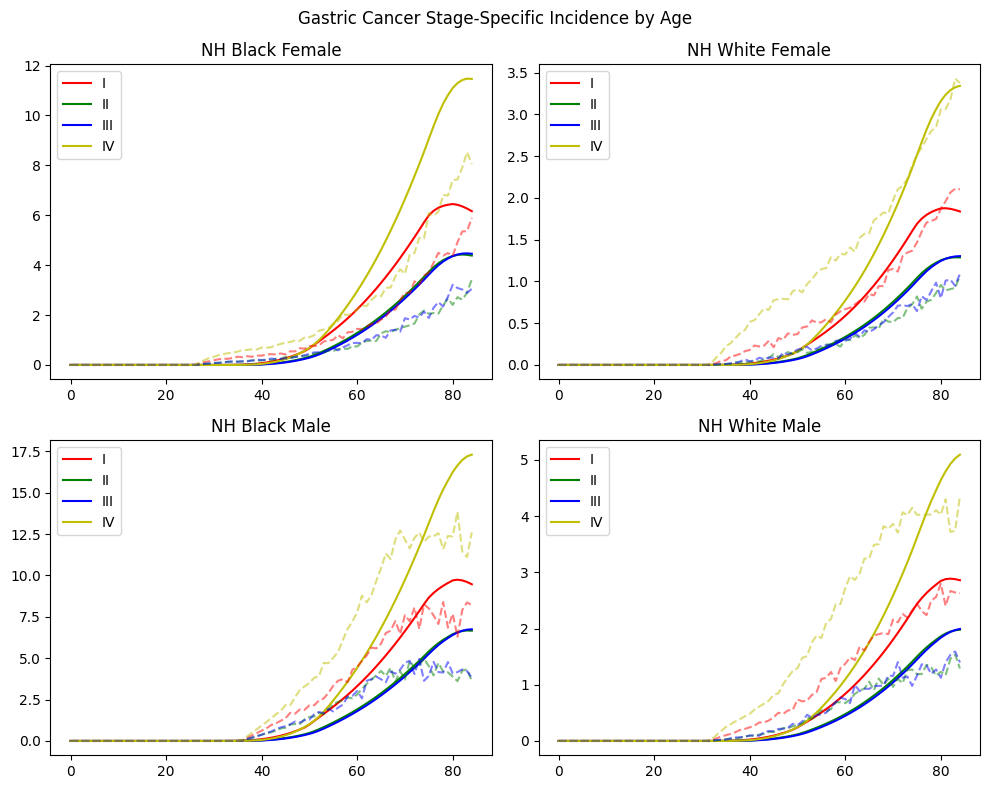

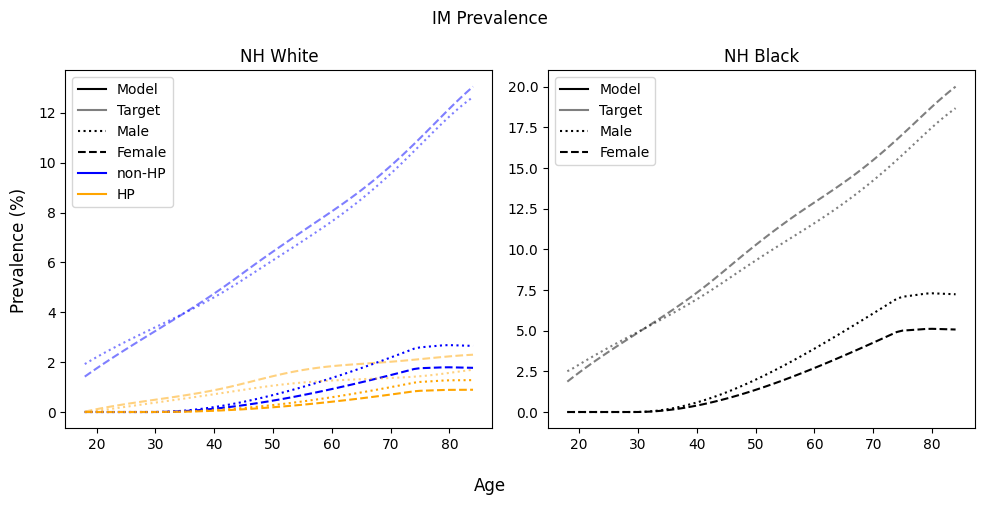

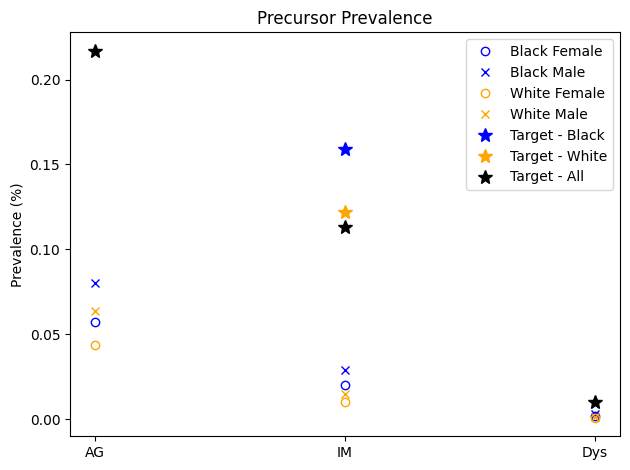

In [51]:
import time

# Running Calibration

# starting_tmat_fname = "Transition Matrices\From_1.1_Initial_Sqrt_Constrained_20241116-085949\From_1.1_Initial_Sqrt_Constrained_20241116-085949.npy"
# starting_tmat = np.load(starting_tmat_fname)
# starting_tmat = col_normalize(hp(seer(all_cause_mort(constrain(csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], np.copy(starting_tmat), smooth=0, axis=2)([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5]).clip(0.0, 1.0))))))
# print("initial score", objective(run(starting_tmat)))

def get_timestamp():
    return time.strftime("%Y%m%d-%H%M%S")

# tmat_name = f"From_1.0_Initial_{get_timestamp()}"
# tmat_name = "From_1.1_Initial_Sqrt_Constrained_Smoothed"
tmat_name = f"1.4_Initial_Regression_AgeTrend"
save_calibration_results = True

# tmat = run_calibration(1_000, 0.001, save=True)  # 10k takes 6 mins
tmat, is_diff = run_calibration(0,
                       0.01,
                       starting_temp=20,
                       num_adj=20,
                       smooth=0.01,
                    #    starting_tmat=starting_tmat,
                    #    starting_tmat_fname=starting_tmat_fname,
                       save=save_calibration_results,
                       tmat_name=tmat_name)

# Basecase calibrated score: 44711.33621536795

In [61]:
import time

# Running Calibration with Benchmarks

def get_timestamp():
    return time.strftime("%Y%m%d-%H%M%S")

starting_tmat_fname = "Transition Matrices\From_1.4_Initial_Regression_AgeTrend_20250110-120906_22\From_1.4_Initial_Regression_AgeTrend_20250110-120906_22.npy"
starting_tmat = np.load(starting_tmat_fname)
# starting_tmat = col_normalize(hp(seer(all_cause_mort(constrain(csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], np.copy(starting_tmat), smooth=0, axis=2)([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5]).clip(0.0, 1.0))))))
# starting_tmat = col_normalize(hp(seer(all_cause_mort(constrain(np.copy(starting_tmat))))))
init_tmat_name= f"From_1.4_Initial_Regression_AgeTrend_{get_timestamp()}"

save_calibration_results = True
total_iters = 1_000_000
num_benchmarks = 100
benchmarks = []

for i in range(num_benchmarks):
    num_iters = total_iters // num_benchmarks if i < num_benchmarks - 1 else total_iters - i*(total_iters // num_benchmarks)
    tmat_name = f"{init_tmat_name}_{i+1}" if i else init_tmat_name
    start_iter = total_iters // num_benchmarks * i
    print("iter: ", start_iter)
    tmat, is_diff = run_calibration(num_iters,
                        step_size= 0.005 if start_iter < 500_000 else 0.001,
                        num_adj=20 if start_iter < 500_000 else 10,
                        smooth=0.01,
                        starting_temp=10 if start_iter < 1_000_000 else 1,
                        starting_tmat=starting_tmat,
                        starting_tmat_fname=starting_tmat_fname,
                        save=save_calibration_results,
                        start_iter = start_iter, 
                        hide_plot=True,
                        tmat_name=tmat_name)
    if is_diff:
        benchmarks.append((tmat_name, tmat))
        starting_tmat = tmat
        starting_tmat_fname = f"Transition Matrices\\{tmat_name}\\{tmat_name}.npy"

# Basecase calibrated score: 44711.33621536795

<>:8: SyntaxWarning: invalid escape sequence '\F'
<>:8: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sys2131\AppData\Local\Temp\ipykernel_22180\1834713746.py:8: SyntaxWarning: invalid escape sequence '\F'
  starting_tmat_fname = "Transition Matrices\From_1.4_Initial_Regression_AgeTrend_20250110-120906_22\From_1.4_Initial_Regression_AgeTrend_20250110-120906_22.npy"


iter:  0
>0 score = 1266.82161
1266.821607875735
iter:  10000
>0 score = 1266.82161
1265.0943699279417
Saving log...
Done
iter:  20000
>0 score = 1265.09437
1265.0943699279417
iter:  30000
>0 score = 1265.09437
1265.0943699279417
iter:  40000
>0 score = 1265.09437
1265.0943699279417
iter:  50000
>0 score = 1265.09437
1265.0943699279417
iter:  60000
>0 score = 1265.09437
1265.0943699279417
iter:  70000
>0 score = 1265.09437
1265.0943699279417
iter:  80000
>0 score = 1265.09437
1265.0943699279417
iter:  90000
>0 score = 1265.09437
1265.0943699279417
iter:  100000
>0 score = 1265.09437
1265.0943699279417
iter:  110000
>0 score = 1265.09437
1265.0943699279417
iter:  120000
>0 score = 1265.09437
1265.0943699279417
iter:  130000
>0 score = 1265.09437
1265.0943699279417
iter:  140000
>0 score = 1265.09437
1265.0943699279417
iter:  150000
>0 score = 1265.09437
1265.0943699279417
iter:  160000
>0 score = 1265.09437
1265.0943699279417
iter:  170000
>0 score = 1265.09437
1265.0943699279417
iter: 

In [ ]:
objective(run(tmat))

(np.float64(9819.35294700013),
 {'Inc': np.float64(2283.7303855924447),
  'IM Prev W': np.float64(4882.187252706203),
  'IM Prev B': np.float64(2549.370742085765),
  'AG Prev': np.float64(103.45398812606413),
  'Dys Prev': np.float64(0.6105784896538794)})

# Smooth and Anchor Transition Matrix
- Use cubic spline interpolation to interpolate probabilities from 18-100
- Anchor increasing parameters at age 100 to prevent exponential incidence increase

In [23]:
import os
def smooth_tmat(mat, save=False, folder="", name=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[:, :, -1:, :, :], np.mean(mat, axis=2, keepdims=True))], axis=2) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)

    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=2)(np.linspace(18,100,83)) # interpolation without anchoring
  
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5, 100], tmat_anchored, smooth=0.01, axis=2)(np.linspace(18,100,83)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[:, :, -2:-1, :, :] < tmat[:, :, -1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((18, 18), dtype=bool)
    from_states, to_states, _ = zip(*calibrated_trans)
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, np.newaxis, np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    # HANDLE NEGATIVE CASE: Sometimes spline dips below 0 and becomes positive again, causing a spike after clipping the matrix to 0 and 1.
    # Find the index of the first negative before a positive index from the last age
    neg_after_pos = ((tmat[:, :, :-1, :, :] >= 0) & (tmat[:, :, 1:, :, :] < 0)) # any negative after positive marked True
    neg_after_pos = np.insert(neg_after_pos, 0, False, axis=2) # insert False at the first index to make arr shape same as tmat, by definition first idx is False
    neg_after_pos_reversed = np.flip(neg_after_pos, axis=2)
    last_neg_after_pos_til_end = np.flip(np.where(np.cumsum(neg_after_pos_reversed, axis=2) == 0, True, neg_after_pos_reversed), axis=2) # reverse to find the last True, set values from last True until end to True
    mask = np.any(neg_after_pos, axis=2).reshape(2, 2, 1, 18, 18) & last_neg_after_pos_til_end # only apply this to indices that have negative at the end
    # Set indices from last negative after positive to end to zero
    tmat[mask] = 0

    tmat = col_normalize(tmat)

    if save:
      os.makedirs(folder, exist_ok=True)
      # Save tmat
      np.save(f"{folder}/{name}.npy", tmat)
    return tmat

In [25]:
import os
# Visualize microsim parameters
def plot_params(markov_tmat, microsim_tmat, save=False, hide_plot=False, folder="", name=""):
    # parameters = [
    #                 (2,0,'Healthy -> AG'),
    #                 (3,1,'HP -> AG'),
    #                 (4,2,'AG -> IM'),
    #                 (5,3,'AG (HP) -> IM (HP)'),
    #                 (6,4,'IM -> DYS'),
    #                 (7,5,'IM (HP) -> DYS (HP)'),
    #                 (8,6,'DYS -> U GC 1'),
    #                 (8,7,'DYS (HP) -> U GC 1'),
    #                 (8,0,'Healthy -> U GC 1'),
    #                 (9,8,'U GC 1 -> U GC 2'),
    #                 (10,9,'U GC 2 -> U GC 3'),
    #                 (11,10,'U GC 3 -> U GC 4'),
    #                 (12,8,'U GC 1 -> D GC 1'),
    #                 (13,9,'U GC 2 -> D GC 2'),
    #                 (14,10,'U GC 3 -> D GC 3'),
    #                 (15,11,'U GC 4 -> D GC 4'),
    #                 ]
    parameters = calibrated_trans
    fig = plt.figure(constrained_layout=True)
    fig.set_figwidth(12)
    fig.set_figheight(3.5*len(parameters))
    fig.supylabel("Transition Probability")
    fig.supxlabel("Age")
    subfigs = fig.subfigures(nrows=len(parameters), ncols=1)

    age_bucket_midpts = [25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5]

    for row, subfig in enumerate(subfigs):
        p_set = parameters[row]
        subfig.suptitle(p_set[2])

        # create 1x2 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
        for col, ax in enumerate(axs):
            ax.plot(np.linspace(18,100,83), microsim_tmat[0,col,:,p_set[0],p_set[1]], label='Female', ls = '--', alpha=0.5)
            ax.scatter(age_bucket_midpts, markov_tmat[0,col,:,p_set[0],p_set[1]], label='Female')
            ax.plot(np.linspace(18,100,83), microsim_tmat[1,col,:,p_set[0],p_set[1]], label='Male', alpha=0.5)
            ax.scatter(age_bucket_midpts, markov_tmat[1,col,:,p_set[0],p_set[1]], label='Male')
            ax.set_title('NH Black' if col == 0 else "NH White")
            if row == 0 and col == 1:
              ax.legend()

    if save:
       os.makedirs(folder, exist_ok=True)
       fig.savefig(f"{folder}/{name}.png")

    if hide_plot:
        plt.close()

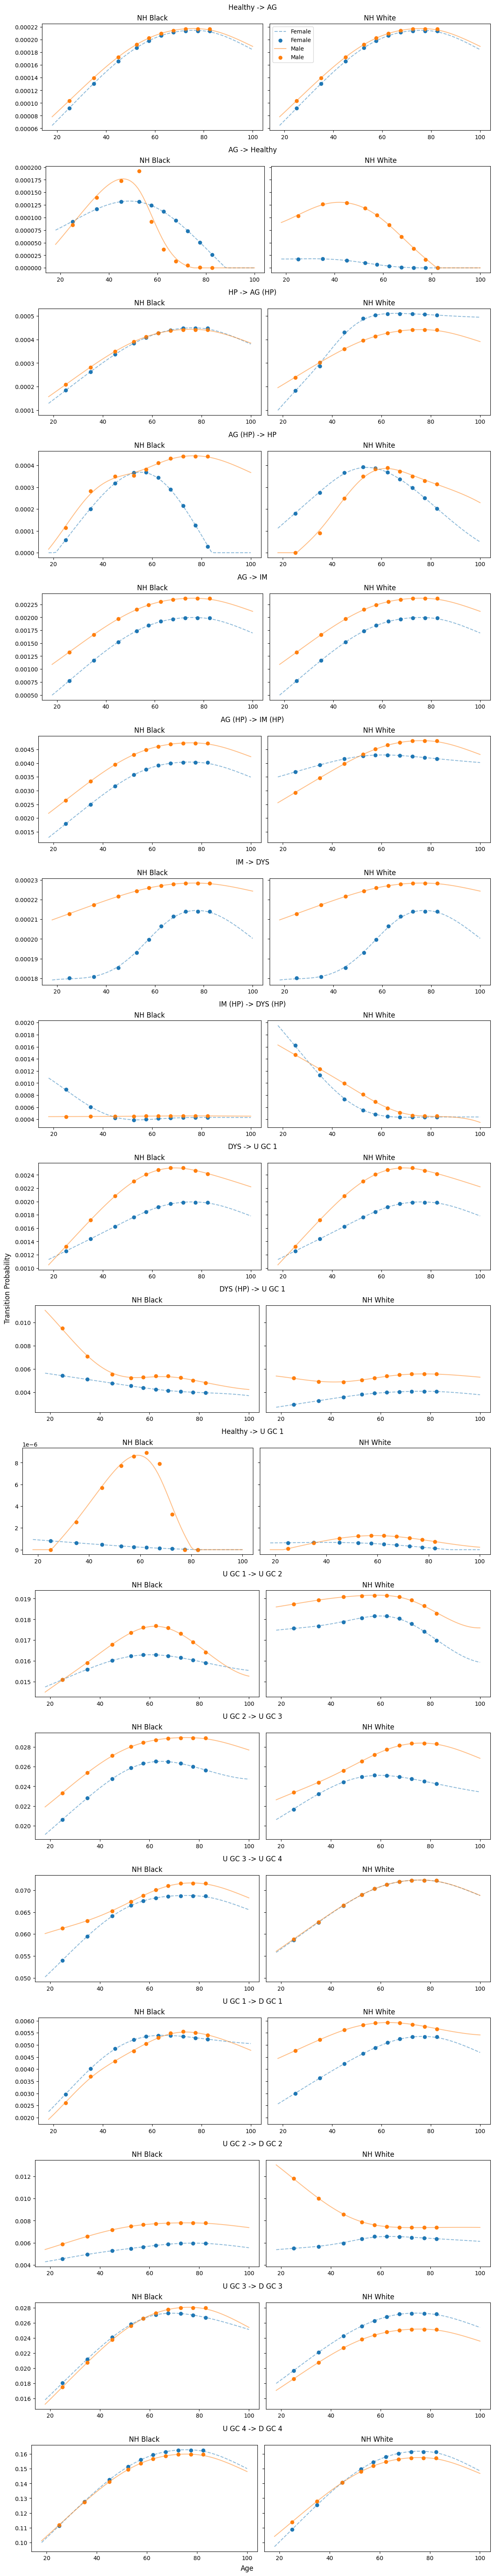

In [62]:
# Prepare for microsim and plot
save_calibration_results=True
tmat_name = "From_1.4_Initial_Regression_AgeTrend_20250110-180243_72"
folder = f"Transition Matrices\\{tmat_name}"
# tmat = np.load(f"{folder}\\{tmat_name}.npy")
# tmat = col_normalize(hp(seer(all_cause_mort(constrain(np.copy(tmat))))))

folder = f"Transition Matrices\\{tmat_name}"
markov_tmat = tmat
microsim_tmat = smooth_tmat(markov_tmat, save=True, folder=folder, name="Microsim")
plot_params(markov_tmat, microsim_tmat, save=save_calibration_results, folder=folder, name="microsim_parameters")
# plot_params(markov_tmat, microsim_tmat, save=True, folder=f"Transition Matrices/Basecase_20241030-162536", name="microsim_parameters")


In [57]:
# Prepare for microsim and plot (benchmarks)
for tmat_name, tmat in benchmarks:
    markov_tmat = tmat
    microsim_tmat = smooth_tmat(markov_tmat, save=False)
    plot_params(markov_tmat, microsim_tmat, save=save_calibration_results, hide_plot=True, folder=f"Transition Matrices/{tmat_name}", name="microsim_parameters")